In [118]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
import time

In [2]:
def body_to_nav(roll, pitch, yaw):
    cr = np.cos(roll)
    sr = np.sin(roll)
    cp = np.cos(pitch)
    sp = np.sin(pitch)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    dcm = np.array([[cp*cy, -cr*sy+sr*sp*cy, sr*sy+cr*sp*cy],
                    [cp*sy, cr*cy+sr*sp*sy, -sr*cy+cr*sp*sy],
                    [-sp, sr*cp, cr*cp]])
    
    return dcm

In [3]:
def quat_to_euler(quat):
    # Converts a quaternion matrix [w, x, y, z] into an Euler angle [roll, pitch, yaw] matrix
    euler = np.zeros(shape=(quat.shape[0], 3))
    for i in range(quat.shape[0]):
        qw, qx, qy, qz = quat[i, :]
        roll = np.arctan2(2*(qw*qx+qy*qz), 1-2*(qx**2+qy**2))
        pitch = -np.pi/2 + 2*np.arctan2(np.sqrt(1+2*(qw*qy-qx*qz)), np.sqrt(1-2*(qw*qy-qx*qz)))
        yaw = np.arctan2(2*(qw*qz+qx*qy), 1-2*(qy**2+qz**2))
        euler[i,:] = [roll, pitch, yaw]
    return euler

In [4]:
def process_trajectory(traj, data_params, train_mode=False):
    """Data import from file"""
    # GPS
    gps_pos = traj['gps']['position']
    # Ground truth
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    gnd_vel = traj['groundtruth']['velocity']
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    """Sample high frequency IMU data to the same frequency as GPS"""
    # Get average IMU data for each timestep of GPS data (IMU 100Hz, GPS 1Hz)
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    accel_data = np.zeros(shape=(imu_sumdiv+1,3))
    accel_data[0,:] = imu_acc[0,:]
    gyro_data = np.zeros(shape=(imu_sumdiv+1,3))
    gyro_data[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        accel_data[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        gyro_data[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)
    
    """Sample attitude or integrate gyros"""
    if data_params["TRUE_ATT"]:
        # Get average attitude data for each timestep of GPS data (attitude 100Hz, GPS 1Hz)
        gnd_sumdiv = int(np.floor(gnd_att.shape[0]/100))
        attitude_data = np.zeros(shape=(gnd_sumdiv+1,3))
        attitude_data[0,:] = gnd_att[0,:]
        for i in range(gnd_sumdiv):
            attitude_data[i+1,:] = np.average(gnd_att[1+100*i:1+100*(i+1),:], axis=0)
    else:
        gyro_integration = np.zeros_like(gyro_data)
        gyro_integration[0,:] = gnd_att[0,:]
        for i in range(1, gyro_integration.shape[0]):
            gyro_integration[i,:] = gyro_integration[i-1,:] + (gyro_data[i,[1, 0, 2]] * [-1, 1, 1])
        # gyro_integration = gyro_integration[:, [1, 0, 2]] * [-1, 1, 1]
        attitude_data = gyro_integration

    """Transfor accelerometer from body to nav"""
    if data_params["ACCEL_TO_NAV"]:
        for i in range(accel_data.shape[0]):
            roll, pitch, yaw = attitude_data[i,:]
            accel_data[i,:] = body_to_nav(roll=roll, pitch=pitch, yaw=yaw) @ accel_data[i,:]
        accel_data = accel_data - [0, 0, -9.81]
    
    """Sample velocity or integrate accelerometers"""
    if data_params["TRUE_VEL"]:
        # Get average velocity data for each timestep of GPS data (attitude 100Hz, GPS 1Hz)
        gnd_sumdiv = int(np.floor(gnd_vel.shape[0]/100))
        velocity_data = np.zeros(shape=(gnd_sumdiv+1,3))
        velocity_data[0,:] = gnd_vel[0,:]
        for i in range(gnd_sumdiv):
            velocity_data[i+1,:] = np.average(gnd_vel[1+100*i:1+100*(i+1),:], axis=0)
    else:
        accel_integration = np.zeros_like(accel_data)
        accel_integration[0,:] = gnd_vel[0,:]
        for i in range(1, accel_integration.shape[0]):
            accel_integration[i,:] = accel_integration[i-1,:] + accel_data[i,:]
        velocity_data = accel_integration

    """Form GPS delta data"""
    # Change in GPS position
    gps_delta = gps_pos[1:,:] - gps_pos[:-1,:]
    gps_delta = np.vstack((np.zeros(shape=(1,3)), gps_delta))

    """Normalize input data"""
    if data_params["NORMALIZE_INPUT"]:
        if train_mode:
            # Accel
            acc_mean = np.mean(accel_data, axis=0)
            data_params["acc_mean"] = acc_mean
            acc_std  = np.std(accel_data, axis=0)
            data_params["acc_std"] = acc_std
            # Gyro
            gyr_mean = np.mean(gyro_data, axis=0)
            data_params["gyr_mean"] = gyr_mean
            gyr_std  = np.std(gyro_data, axis=0)
            data_params["gyr_std"] = gyr_std
            # Attitude
            att_mean = np.mean(attitude_data, axis=0)
            data_params["att_mean"] = att_mean
            att_std  = np.std(attitude_data, axis=0)
            data_params["att_std"] = att_std
            # Velocity
            vel_mean = np.mean(velocity_data, axis=0)
            data_params["vel_mean"] = vel_mean
            vel_std  = np.std(velocity_data, axis=0)
            data_params["vel_std"] = vel_std

            accel_data = (accel_data - acc_mean)/acc_std
            gyro_data = (gyro_data - gyr_mean)/gyr_std
            attitude_data = (attitude_data - att_mean)/att_std
            velocity_data = (velocity_data - vel_mean)/vel_std
        else:
            accel_data = (accel_data - data_params["acc_mean"])/data_params["acc_std"]
            gyro_data = (gyro_data - data_params["gyr_mean"])/data_params["gyr_std"]
            attitude_data = (attitude_data - data_params["att_mean"])/data_params["att_std"]
            velocity_data = (velocity_data - data_params["vel_mean"])/data_params["vel_std"]
    
    """Normalize output data"""
    if data_params["NORMALIZE_OUTPUT"]:
        if train_mode:
            gps_mean = np.mean(gps_delta, axis=0)
            data_params["gps_mean"] = gps_mean
            gps_std  = np.std(gps_delta, axis=0)
            data_params["gps_std"] = gps_std

            gps_delta = (gps_delta - gps_mean)/gps_std
        else:
            gps_delta = (gps_delta - data_params["gps_mean"])/data_params["gps_std"]

    return gps_delta, accel_data, gyro_data, attitude_data, velocity_data

In [5]:
def test_model(traj, model, data_params):
    gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=False)

    dp_ = gps_delta.shape[0]
    Y_pred_ = np.zeros(shape=(dp_,3))
    for i in range(dp_):
        if i <= data_params["MODEL_DELAY"]:
            # STILL NEED MORE DATA
            Y_pred_[i,:] = gps_delta[i,:]
        else:
            # ENOUGH DATA
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [accel_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [gyro_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [attitude_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_VELO"]:
                X_ = np.hstack((X_, [velocity_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [Y_pred_[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            Y_ = model(X_)
            Y_pred_[i,:] = Y_
    return Y_pred_, gps_delta

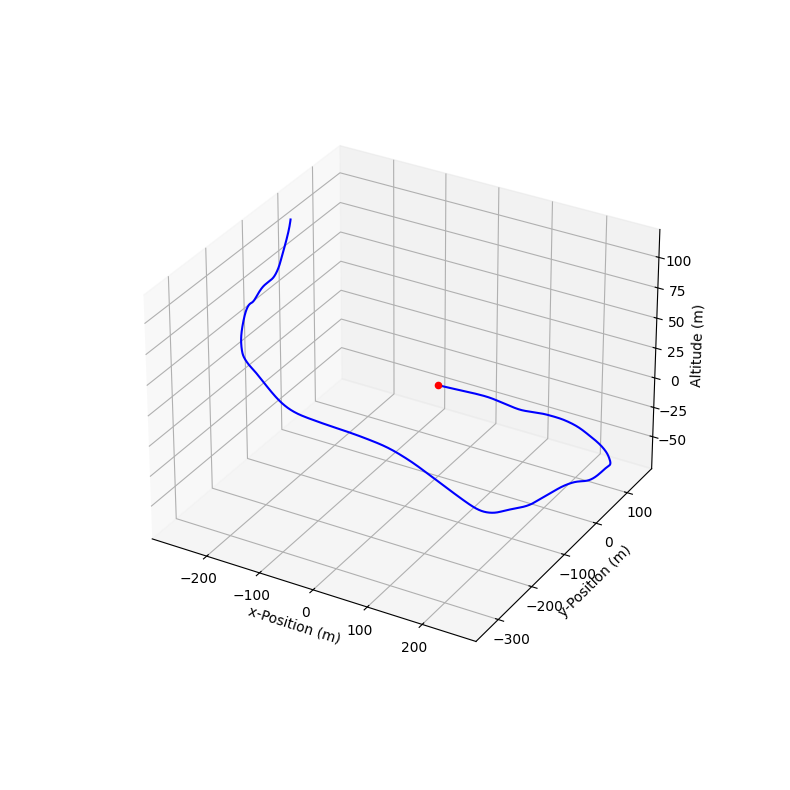

In [78]:
f = h5py.File('data/drone_sim/sunny.hdf5')
traj_name = f"trajectory_0015"
traj = f[traj_name]

gnd_pos = traj["groundtruth"]["position"]

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot(gnd_pos[:,0], gnd_pos[:,1], gnd_pos[:,2], c="blue")
ax.scatter(gnd_pos[0,0], gnd_pos[0,1], gnd_pos[0,2], c="red", label="Start")
ax.set_xlabel("x-Position (m)")
ax.set_ylabel("y-Position (m)")
ax.set_zlabel("Altitude (m)")
# ax.legend()
ax.set_box_aspect(None, zoom=0.75)
plt.show()

In [103]:
f = h5py.File('data/drone_sim/sunny.hdf5')
train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
             '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

data_params = {"MODEL_DELAY": 1, 
               "NORMALIZE_INPUT": 1, 
               "NORMALIZE_OUTPUT": 1, 
               "INPUT_ACCL": 1, 
               "INPUT_GYRO": 1, 
               "INPUT_ATTI": 1, 
               "INPUT_VELO": 1,
               "INPUT_POUT": 1,
               "TRUE_ATT": 1,
               "TRUE_VEL": 0,
               "ACCEL_TO_NAV": 1
}

"""Autoregressive exogeneous model trainset creation"""
# Construct training data set
Y_train = np.zeros(shape=(0,3))
features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
X_train = np.zeros(shape=(0,features))
for i, traj_num in enumerate(train_set):
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
    # Construct training set
    model_delay = data_params["MODEL_DELAY"]
    dp_ = gps_delta.shape[0]-model_delay
    Y_train_ = np.zeros(shape=(dp_, 3))
    X_train_ = np.zeros(shape=(dp_, features))
    for i in range(dp_):
        Y_ = gps_delta[i+model_delay,:]
        Y_train_[i,:] = Y_
        X_ = np.zeros(shape=(1,0))
        if data_params["INPUT_ACCL"]:
            X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_GYRO"]:
            X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_ATTI"]:
            X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_VELO"]:
            X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_POUT"]:
            X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
        X_train_[i,:] = X_
    
    # Add to X and Y sets
    X_train = np.vstack((X_train, X_train_))
    Y_train = np.vstack((Y_train, Y_train_))


In [45]:
X_train.shape

(1739, 30)

0.011096715927124023


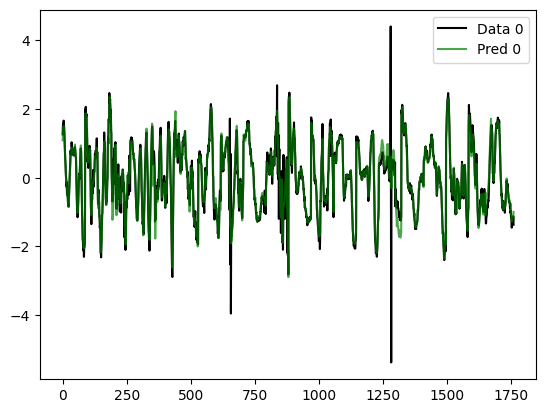

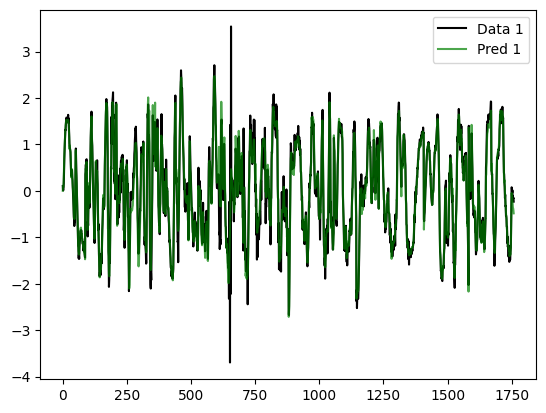

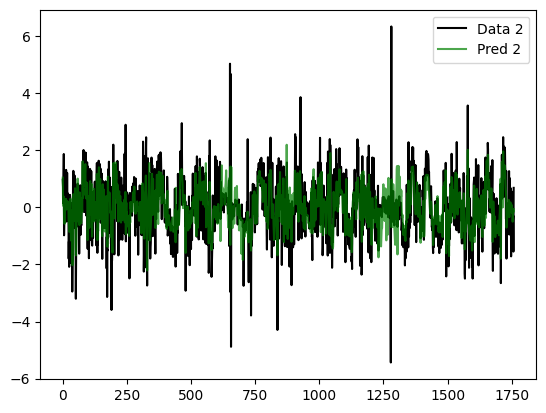

In [119]:
"""Least-squares fitting"""
# Train LS model
BETA_REG = 1e-5
tic = time.time()
dp_, features_ = X_train.shape
_, outputs_ = Y_train.shape
w_ls = np.zeros(shape=(outputs_, features_, 1))
Y_train_ls = np.zeros(shape=(dp_, outputs_))
for i in range(outputs_):
    w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
    Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()
toc = time.time()
print(toc-tic)

def model_ls(x):
    outputs_, _, _ = w_ls.shape
    dp_, _ = x.shape
    y_ = np.zeros(shape=(dp_, outputs_))
    for i in range(outputs_):
        y_[:,i] = (x @ w_ls[i,:,:]).flatten()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_ls[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

In [121]:
X_train.shape

(1759, 15)

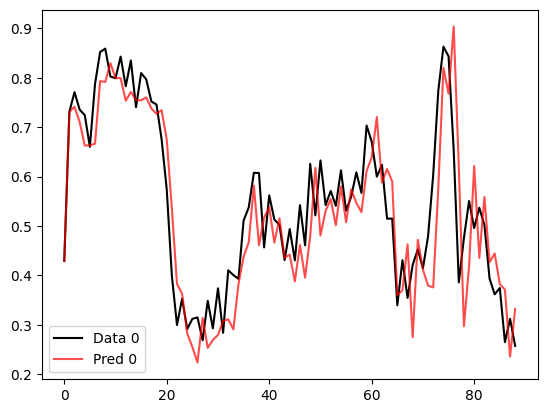

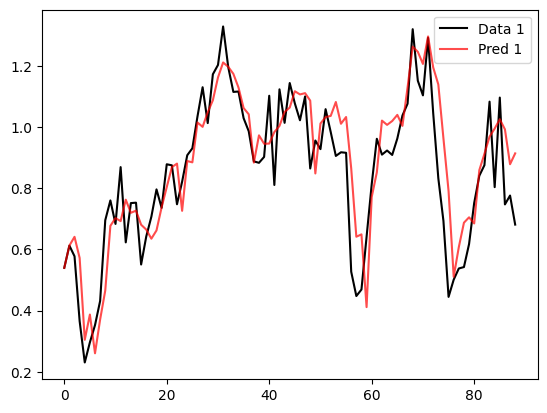

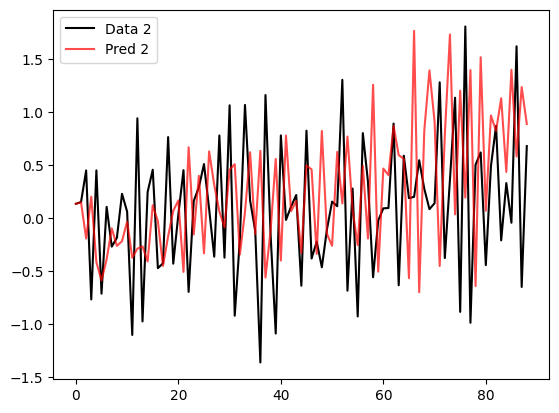

In [105]:
"""Least squares testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0027"]
Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_ls[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

Epoch 1, training loss: 1.0691
Epoch 100, training loss: 0.2244
Epoch 200, training loss: 0.1742


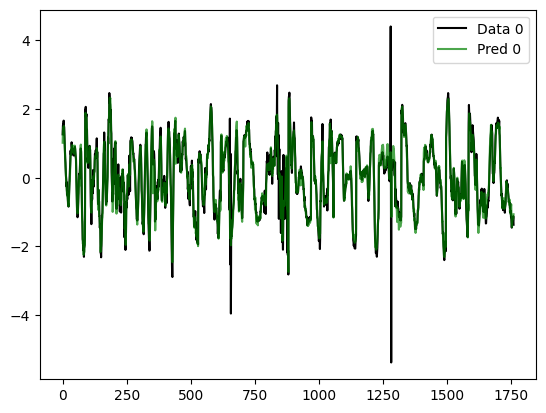

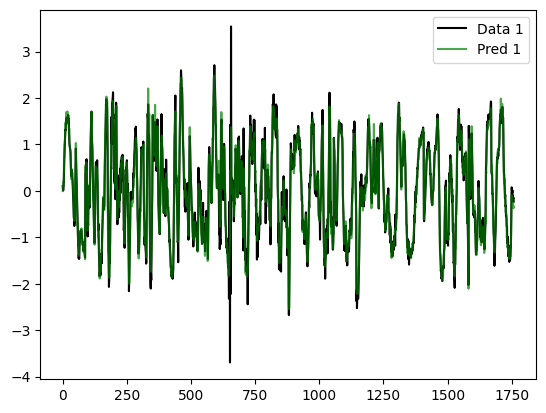

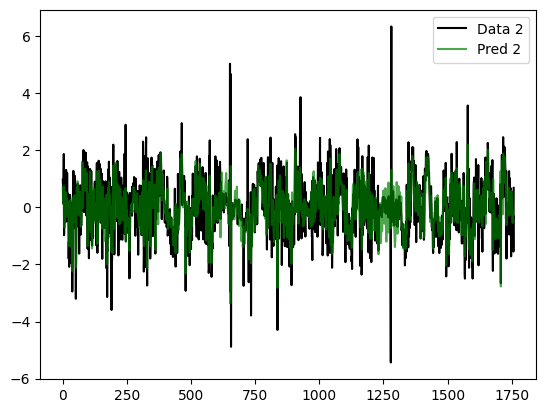

In [123]:
"""Neural network training"""
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)

dp, features = X_train_tensor.shape
_, outputs = Y_train_tensor.shape

NUM_HIDDEN_LAYERS = 128
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
WEIGHT_DECAY = 0
NUM_EPOCHS = 200

# Define model, loss function, and search algorithm
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=8),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=8, out_features=outputs)
)
loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    Y_pred_ = model(X_train_tensor)
    loss_value = loss(Y_pred_, Y_train_tensor)

    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or ((epoch % 100) == 0):
        print(f"Epoch {epoch}, training loss: {loss_value.item():.4f}")

# Evaluate train set
model.eval()
with torch.no_grad():
    Y_train_nn = model(X_train_tensor).numpy()

def model_nn(x):
    x_tensor = torch.from_numpy(x).to(torch.float32)
    model.eval()
    with torch.no_grad():
        y_ = model(x_tensor).numpy()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_nn[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

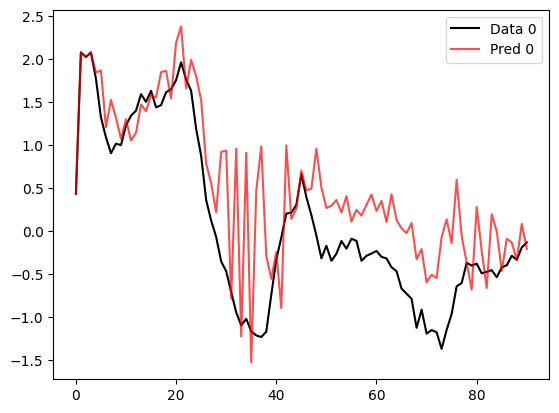

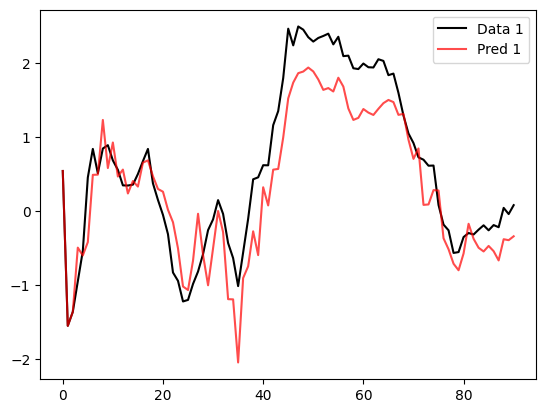

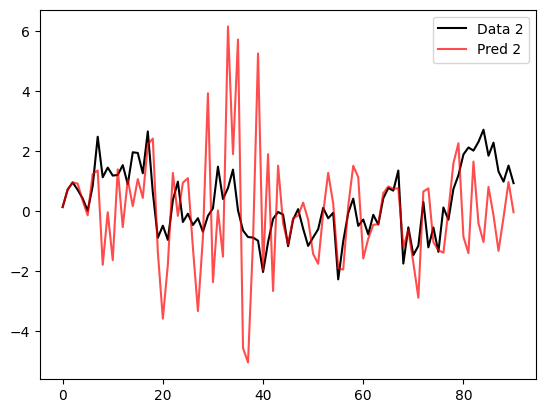

In [41]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0024"]
Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_nn[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

In [124]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
mse_ls_avg = np.zeros(shape=(3,))
mse_nn_avg = np.zeros(shape=(3,))
for traj_num in test_set:
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)
    Y_test_ls, _ = test_model(traj=traj, model=model_ls, data_params=data_params)
    
    mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
    mse_nn = mean_squared_error(Y_test, Y_test_nn, multioutput="raw_values")
    
    mse_ls_avg = mse_ls_avg + mse_ls
    mse_nn_avg = mse_nn_avg + mse_nn

    print(f"\nTraj_{traj_num}")
    print(f"LS: x:{mean_squared_error(Y_test[:,0], Y_test_ls[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}")
    print(f"NN: x:{mean_squared_error(Y_test[:,0], Y_test_nn[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}")
mse_ls_avg = mse_ls_avg/len(test_set)
mse_nn_avg = mse_nn_avg/len(test_set)

print(f"NN: {mse_nn_avg}")
print(f"LS: {mse_ls_avg}")


Traj_0020
LS: x:0.0160 y:0.0705, z:0.0705
NN: x:0.0296 y:0.1016, z:0.1016

Traj_0021
LS: x:0.0534 y:0.0704, z:0.0704
NN: x:0.0804 y:0.1187, z:0.1187

Traj_0022
LS: x:0.0295 y:0.0431, z:0.0431
NN: x:0.0389 y:0.0302, z:0.0302

Traj_0023
LS: x:0.0335 y:0.0554, z:0.0554
NN: x:0.0488 y:0.0884, z:0.0884

Traj_0024
LS: x:0.3027 y:0.2231, z:0.2231
NN: x:0.2942 y:0.2464, z:0.2464

Traj_0025
LS: x:0.0090 y:0.0472, z:0.0472
NN: x:0.0180 y:0.0597, z:0.0597

Traj_0026
LS: x:0.0064 y:0.0210, z:0.0210
NN: x:0.0101 y:0.0308, z:0.0308

Traj_0027
LS: x:0.0075 y:0.0154, z:0.0154
NN: x:0.0203 y:0.0199, z:0.0199

Traj_0028
LS: x:0.0206 y:0.0190, z:0.0190
NN: x:0.0220 y:0.0331, z:0.0331

Traj_0029
LS: x:0.0086 y:0.0246, z:0.0246
NN: x:0.0150 y:0.0290, z:0.0290
NN: [0.05772896 0.07577259 0.9014641 ]
LS: [0.04869831 0.05896752 0.84594146]


In [12]:
traj_name = f"trajectory_0000"
traj = f[traj_name]
vel_data_true = traj["groundtruth"]["velocity"]
att_data_true = quat_to_euler(traj["groundtruth"]["attitude"])

data_params1 = {"MODEL_DELAY": 2, 
               "NORMALIZE_INPUT": 0, 
               "NORMALIZE_OUTPUT": 0, 
               "INPUT_ACCL": 1, 
               "INPUT_GYRO": 1, 
               "INPUT_ATTI": 1, 
               "INPUT_VELO": 1,
               "INPUT_POUT": 1,
               "TRUE_ATT": 0,
               "TRUE_VEL": 0,
               "ACCEL_TO_NAV": 1
}

gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params1, train_mode=False)

In [13]:
true_att_temp = attitude_data

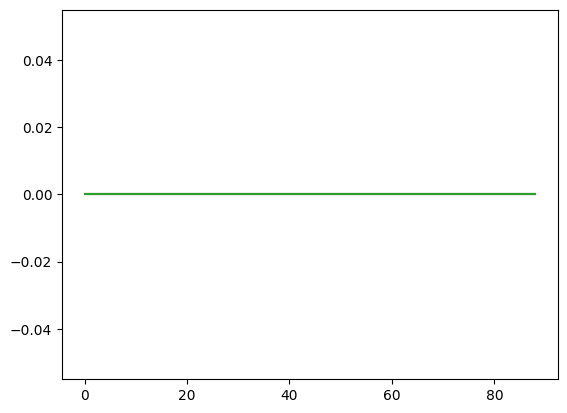

In [14]:
# plt.plot(velocity_data)
plt.plot(attitude_data-true_att_temp)
# plt.plot(accel_data)

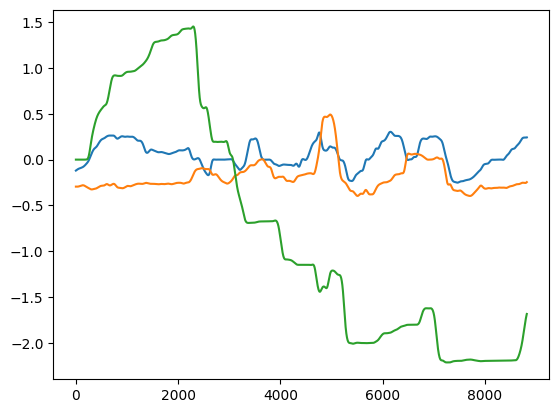

In [15]:
# plt.plot(vel_data_true)
plt.plot(att_data_true)

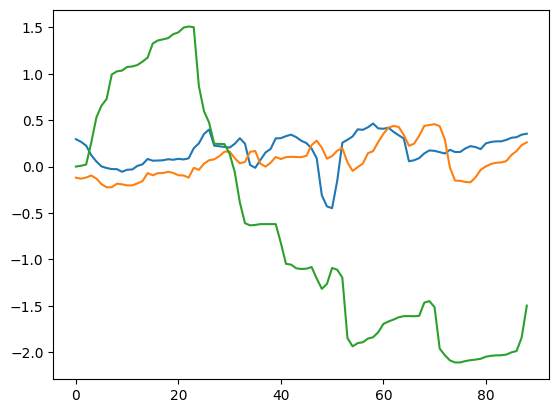

In [16]:
temp = attitude_data[:, [1, 0, 2]]
temp = temp * [-1, 1, 1]
plt.plot(temp)

In [85]:
delay_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
beta_list = [1e-5, 1e-3, 1e-1, 1, 1e1]

results_ls = np.zeros(shape=(len(delay_list), len(beta_list)))

for d_i, d in enumerate(delay_list):
    f = h5py.File('data/drone_sim/sunny.hdf5')
    train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
                '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

    data_params = {"MODEL_DELAY": d, 
                "NORMALIZE_INPUT": 1, 
                "NORMALIZE_OUTPUT": 1, 
                "INPUT_ACCL": 1, 
                "INPUT_GYRO": 1, 
                "INPUT_ATTI": 1, 
                "INPUT_VELO": 1,
                "INPUT_POUT": 1,
                "TRUE_ATT": 1,
                "TRUE_VEL": 0,
                "ACCEL_TO_NAV": 1
    }

    """Autoregressive exogeneous model trainset creation"""
    # Construct training data set
    Y_train = np.zeros(shape=(0,3))
    features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
    X_train = np.zeros(shape=(0,features))
    for i, traj_num in enumerate(train_set):
        traj_name = f"trajectory_{traj_num}"
        traj = f[traj_name]
        gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
        # Construct training set
        model_delay = data_params["MODEL_DELAY"]
        dp_ = gps_delta.shape[0]-model_delay
        Y_train_ = np.zeros(shape=(dp_, 3))
        X_train_ = np.zeros(shape=(dp_, features))
        for i in range(dp_):
            Y_ = gps_delta[i+model_delay,:]
            Y_train_[i,:] = Y_
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_VELO"]:
                X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
            X_train_[i,:] = X_
        
        # Add to X and Y sets
        X_train = np.vstack((X_train, X_train_))
        Y_train = np.vstack((Y_train, Y_train_))
    
    for beta_j, beta in enumerate(beta_list):
        BETA_REG = beta
        dp_, features_ = X_train.shape
        _, outputs_ = Y_train.shape
        w_ls = np.zeros(shape=(outputs_, features_, 1))
        Y_train_ls = np.zeros(shape=(dp_, outputs_))
        for i in range(outputs_):
            w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
            Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()

        def model_ls(x):
            outputs_, _, _ = w_ls.shape
            dp_, _ = x.shape
            y_ = np.zeros(shape=(dp_, outputs_))
            for i in range(outputs_):
                y_[:,i] = (x @ w_ls[i,:,:]).flatten()
            return y_
        
        f = h5py.File('data/drone_sim/sunny.hdf5')
        test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
        mse_ls_avg = np.zeros(shape=(3,))
        for traj_num in test_set:
            traj_name = f"trajectory_{traj_num}"
            traj = f[traj_name]
            Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)
            
            mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
            
            mse_ls_avg = mse_ls_avg + mse_ls

        mse_ls_avg = mse_ls_avg/len(test_set)
        results_ls[d_i,beta_j] = (mse_ls_avg[0] + mse_ls_avg[1])/2
        print(f"Done i:{d_i}, j:{beta_j}")



Done i:0, j:0
Done i:0, j:1
Done i:0, j:2
Done i:0, j:3
Done i:0, j:4
Done i:1, j:0
Done i:1, j:1
Done i:1, j:2
Done i:1, j:3
Done i:1, j:4
Done i:2, j:0
Done i:2, j:1
Done i:2, j:2
Done i:2, j:3
Done i:2, j:4
Done i:3, j:0
Done i:3, j:1
Done i:3, j:2
Done i:3, j:3
Done i:3, j:4
Done i:4, j:0
Done i:4, j:1
Done i:4, j:2
Done i:4, j:3
Done i:4, j:4
Done i:5, j:0
Done i:5, j:1
Done i:5, j:2
Done i:5, j:3
Done i:5, j:4
Done i:6, j:0
Done i:6, j:1
Done i:6, j:2
Done i:6, j:3
Done i:6, j:4
Done i:7, j:0
Done i:7, j:1
Done i:7, j:2
Done i:7, j:3
Done i:7, j:4
Done i:8, j:0
Done i:8, j:1
Done i:8, j:2
Done i:8, j:3
Done i:8, j:4
Done i:9, j:0
Done i:9, j:1
Done i:9, j:2
Done i:9, j:3
Done i:9, j:4


In [86]:
plot_ls_results = np.zeros(shape=(len(delay_list)*len(beta_list),3))
index_counter = 0
for i, d in enumerate(delay_list):
    for j, beta in enumerate(beta_list):
        plot_ls_results[index_counter, :] = [d,beta,results_ls[i,j]]
        index_counter += 1

In [87]:
plot_ls_results

array([[1.00000000e+00, 1.00000000e-05, 5.38329138e-02],
       [1.00000000e+00, 1.00000000e-03, 5.38330178e-02],
       [1.00000000e+00, 1.00000000e-01, 5.38434167e-02],
       [1.00000000e+00, 1.00000000e+00, 5.39380030e-02],
       [1.00000000e+00, 1.00000000e+01, 5.48789306e-02],
       [2.00000000e+00, 1.00000000e-05, 6.29316760e-02],
       [2.00000000e+00, 1.00000000e-03, 6.29271239e-02],
       [2.00000000e+00, 1.00000000e-01, 6.24914858e-02],
       [2.00000000e+00, 1.00000000e+00, 5.97721015e-02],
       [2.00000000e+00, 1.00000000e+01, 5.50286127e-02],
       [3.00000000e+00, 1.00000000e-05, 6.62337775e-02],
       [3.00000000e+00, 1.00000000e-03, 6.62291446e-02],
       [3.00000000e+00, 1.00000000e-01, 6.58626256e-02],
       [3.00000000e+00, 1.00000000e+00, 6.39268839e-02],
       [3.00000000e+00, 1.00000000e+01, 5.70492530e-02],
       [4.00000000e+00, 1.00000000e-05, 6.61878612e-02],
       [4.00000000e+00, 1.00000000e-03, 6.61706876e-02],
       [4.00000000e+00, 1.00000

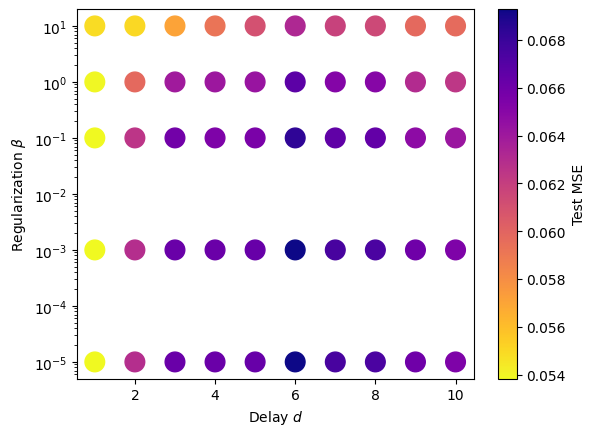

In [99]:
plt.scatter(plot_ls_results[:,0], plot_ls_results[:,1], c=plot_ls_results[:,2], cmap="plasma_r", s=200)
plt.yscale("log")
cbar = plt.colorbar()
cbar.set_label("Test MSE")
plt.xlabel(r"Delay $d$")
plt.ylabel(r"Regularization $\beta$")
plt.show()

In [100]:
results_ls

array([[0.05383291, 0.05383302, 0.05384342, 0.053938  , 0.05487893],
       [0.06293168, 0.06292712, 0.06249149, 0.0597721 , 0.05502861],
       [0.06623378, 0.06622914, 0.06586263, 0.06392688, 0.05704925],
       [0.06618786, 0.06617069, 0.06537428, 0.0641334 , 0.0592072 ],
       [0.06628597, 0.06627384, 0.0655894 , 0.06431908, 0.06106187],
       [0.06928669, 0.06926763, 0.06832692, 0.06671647, 0.063195  ],
       [0.06749827, 0.06747731, 0.06657894, 0.06517988, 0.06183728],
       [0.06738097, 0.06736171, 0.06646887, 0.06507561, 0.06149004],
       [0.06599244, 0.06596676, 0.06481278, 0.06306338, 0.05976154],
       [0.06541112, 0.06538542, 0.06418301, 0.06245051, 0.05963381]])

In [102]:
np.min(results_ls)

0.05383291377714332

In [ ]:
"""Least squares testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0027"]
Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_ls[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

Text(0.5, 0, 'Time (s)')

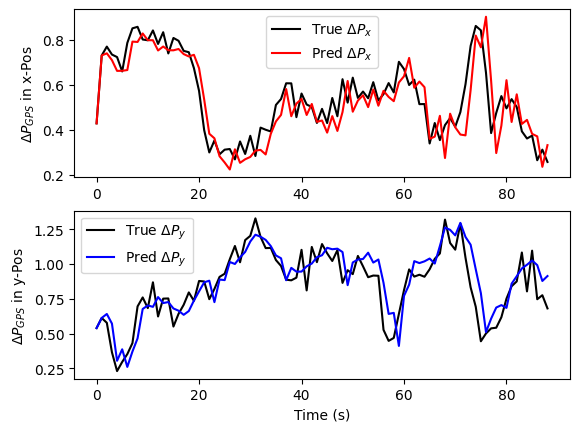

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(Y_test[:,0], c="black", label=r"True $\Delta P_{x}$")
ax[0].plot(Y_test_ls[:,0], c="red", label=r"Pred $\Delta P_{x}$")
ax[0].legend()
ax[0].set_ylabel(r"$\Delta P_{GPS}$ in x-Pos")

ax[1].plot(Y_test[:,1], c="black", label=r"True $\Delta P_{y}$")
ax[1].plot(Y_test_ls[:,1], c="blue", label=r"Pred $\Delta P_{y}$")
ax[1].legend()
ax[1].set_ylabel(r"$\Delta P_{GPS}$ in y-Pos")
ax[1].set_xlabel("Time (s)")